# 08a: Gaussian Process


**Solution:** [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/lectures/08-deeponet/08a-gp.ipynb)

Let's delve into understanding Gaussian processes through practical examples.

Consider a dataset where regression targets (outputs) $y$ are indexed by inputs $x$. For instance, these targets might represent vibration levels of a machine, while the inputs correspond to the times when these measurements were taken. Observing the data, we should ask several questions:

  * What distinct characteristics does the data exhibit?
  * How rapidly does the data seem to change?
  * Are data points gathered at consistent intervals, or are there gaps in the input?
  * How would you predict or interpolate values in areas where data is absent, or project future values up to $x=25$?

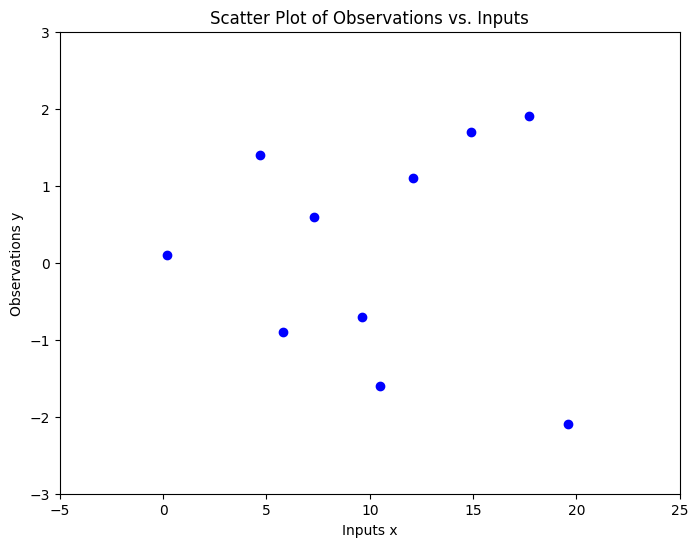

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Generating the x and y data arrays with floats
x = np.array([0.2, 4.7, 5.8, 7.3, 9.6, 10.5, 12.1, 14.9, 17.7, 19.6])
y = np.array([0.1, 1.4, -0.9, 0.6, -0.7, -1.6, 1.1, 1.7, 1.9, -2.1])

# Plotting the data
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue')
plt.xlabel('Inputs x')
plt.ylabel('Observations y')
plt.xlim([-5, 25])
plt.ylim([-3, 3])
plt.title('Scatter Plot of Observations vs. Inputs')
plt.show()


To fit the data using a Gaussian process, we first define a prior distribution based on potential functions that seem plausible. We present various sample functions derived from this Gaussian process. Does the prior appear suitable? It's important to note that we're not seeking functions that precisely match our dataset. Instead, we aim to determine general characteristics of the solutions, like the rate at which they change in response to different inputs.



A Gaussian process is defined as _a collection of random variables, any finite number of which have a joint Gaussian distribution_. If a function $f(x)$ is a Gaussian process, with _mean function_ $m(x)$ and _covariance function_ or _kernel_ $k(x,x')$, $f(x) \sim \mathcal{GP}(m, k)$, then any collection of function values queried at any collection of input points $x$ (times, spatial locations, image pixels, etc.), has a joint multivariate Gaussian distribution with mean vector $\mu$ and covariance matrix $K$: $f(x_1),\dots,f(x_n) \sim \mathcal{N}(\mu, K)$, where $\mu_i = E[f(x_i)] = m(x_i)$ and $K_{ij} = \textrm{Cov}(f(x_i),f(x_j)) = k(x_i,x_j)$.

This definition may seem abstract and inaccessible, but Gaussian processes are in fact very simple objects. Any function

$$f(x) = w^{\top} \phi(x) = \langle w, \phi(x) \rangle,$$

with $w$ drawn from a Gaussian (normal) distribution, and $\phi$ being any vector of basis functions, for example $\phi(x) = (1, x, x^2, ..., x^d)^{\top}$,
is a Gaussian process. Moreover, any Gaussian process f(x) can be expressed in the form of equation. Let's consider a few concrete examples, to begin getting acquainted with Gaussian processes, after which we can appreciate how simple and useful they really are.

## Gaussian Process Prior

### The Radial Basis Function (RBF) Kernel

The _radial basis function_ (RBF) kernel is the most popular covariance function for Gaussian processes, and kernel machines in general.
This kernel has the form $k_{\textrm{RBF}}(x,x') = a^2\exp\left(-\frac{1}{2\ell^2}||x-x'||^2\right)$, where $a$ is an amplitude parameter, and $\ell$ is a _lengthscale_ hyperparameter.

Let's derive this kernel starting from weight space. Consider the function

$$f(x) = \sum_{i=1}^J w_i \phi_i(x), w_i  \sim \mathcal{N}\left(0,\frac{\sigma^2}{J}\right), \phi_i(x) = \exp\left(-\frac{(x-c_i)^2}{2\ell^2 }\right).$$

$f(x)$ is a sum of radial basis functions, with width $\ell$, centred at the points $c_i$, as shown in the following figure.


We can recognize $f(x)$ as having the form $w^{\top} \phi(x)$, where $w = (w_1,\dots,w_J)^{\top}$ and $\phi(x)$ is a vector containing each of the radial basis functions. The covariance function of this Gaussian process is then

$$k(x,x') = \frac{\sigma^2}{J} \sum_{i=1}^{J} \phi_i(x)\phi_i(x').$$

Now let's consider what happens as we take the number of parameters (and basis functions) to infinity. Let $c_J = \log J$, $c_1 = -\log J$, and $c_{i+1}-c_{i} = \Delta c = 2\frac{\log J}{J}$, and $J \to \infty$. The covariance function becomes the Riemann sum:

$$k(x,x') = \lim_{J \to \infty} \frac{\sigma^2}{J} \sum_{i=1}^{J} \phi_i(x)\phi_i(x') = \int_{c_0}^{c_\infty} \phi_c(x)\phi_c(x') dc.$$

By setting $c_0 = -\infty$ and $c_\infty = \infty$, we spread the infinitely many basis functions across the whole real line, each
a distance $\Delta c \to 0$ apart:

$$k(x,x') = \int_{-\infty}^{\infty} \exp(-\frac{(x-c)^2}{2\ell^2}) \exp(-\frac{(x'-c)^2}{2\ell^2 }) dc = \sqrt{\pi}\ell \sigma^2 \exp(-\frac{(x-x')^2}{2(\sqrt{2} \ell)^2}) \propto k_{\textrm{RBF}}(x,x').$$

It is worth taking a moment to absorb what we have done here. By moving into the function space representation, we have derived how to represent a model with an _infinite_ number of parameters, using a finite amount of computation. A Gaussian process with an RBF kernel is a _universal approximator_, capable of representing any continuous function to arbitrary precision. We can intuitively see why from the above derivation. We can collapse each radial basis function to a point mass taking $\ell \to 0$, and give each point mass any height we wish.

So a Gaussian process with an RBF kernel is a model with an infinite number of parameters and much more flexibility than any finite neural network. Perhaps all the fuss about _overparametrized_ neural networks is misplaced. As we will see, GPs with RBF kernels do not overfit, and in fact provide especially compelling generalization performance on small datasets. Moreover, the examples in :cite:`zhang2021understanding`, such as the ability to fit images with random labels perfectly, but still generalize well on structured problems, (can be perfectly reproduced using Gaussian processes) :cite:`wilson2020bayesian`. Neural networks are not as distinct as we make them out to be.

We can build further intuition about Gaussian processes with RBF kernels, and hyperparameters such as _length-scale_, by sampling directly from the distribution over functions. As before, this involves a simple procedure:

1. Choose the input $x$ points we want to query the GP: $x_1,\dots,x_n$.
2. Evaluate $m(x_i)$, $i = 1,\dots,n$, and $k(x_i,x_j)$ for $i,j = 1,\dots,n$ to respectively form the mean vector and covariance matrix $\mu$ and $K$, where $(f(x_1),\dots,f(x_n)) \sim \mathcal{N}(\mu, K)$.
3. Sample from this multivariate Gaussian distribution to obtain the sample function values.
4. Sample more times to visualize more sample functions queried at those points.

We illustrate this process in the figure below.

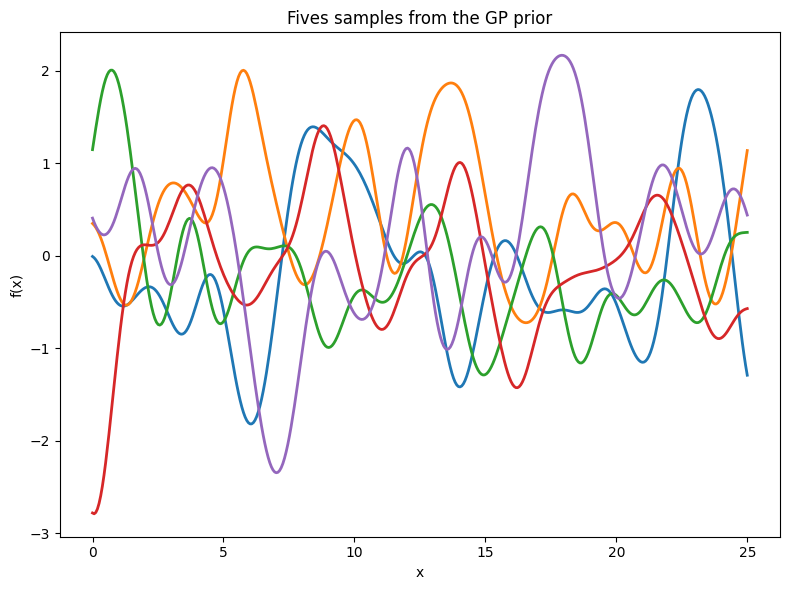

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Radial Basis Function kernel
def rbf_kernel(x1, x2, l=1.0, sigma_f=1.0):
    sqdist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

# Generate x values
x1 = np.linspace(0, 25, 400).reshape(-1, 1)

# Compute the covariance matrix using the RBF kernel
K = rbf_kernel(x1, x1)

# Draw three samples from the zero-mean multivariate Gaussian prior
np.random.seed(42)
f_prior = np.random.multivariate_normal(mean=np.zeros(400), cov=K, size=5)

plt.figure(figsize=(8, 6))
for i in range(5):
    plt.plot(x1, f_prior[i], linestyle='-', lw=2)
plt.title('Fives samples from the GP prior')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.tight_layout()
plt.show()

## Gaussian Process Inference/Posterior

we will show how to perform posterior inference and make predictions using the GP priors we introduced in the last section.

Once we condition on data, we can use this prior to infer a posterior distribution over functions that could fit the data. Here, we show sample posterior functions.

We see that each function is consistent with our data, perfectly running through each observation. In order to use these posterior samples to make predictions, we can average the values of every possible sample function from the posterior to create the curve below in thick blue. Note that we do not have to take an infinite number of samples to compute this expectation, we can compute the expectation in closed form.


When we discuss the Gaussian process posterior, we aim to predict the function values \( f^* \) at new input points \( X^* \) given some training data \( X \) and \( y \). The joint distribution of the observed data and the predictions is:

$$
\begin{bmatrix}
f \\
f^* \\
\end{bmatrix}
\sim
\mathcal{N} \left( 0,
\begin{bmatrix}
K & K^* \\
K^{*T} & K^{**} \\
\end{bmatrix}
\right)
$$

Where:

- \( K \) is the covariance matrix of the training data.
- \( K^* \) is the covariance matrix between the training data and the new input points.
- \( K^{**} \) is the covariance matrix of the new input points.

From the above joint distribution, we can obtain the conditional distribution of \( f^* \) given \( f \) (i.e., the GP posterior) directly. The mean and covariance of this distribution are:

$$
f^* | X^*, X, y \sim \mathcal{N}(\mu, \Sigma)
$$
$$
\mu = K^{*T} K^{-1} y
$$
$$
\Sigma = K^{**} - K^{*T} K^{-1} K^*
$$


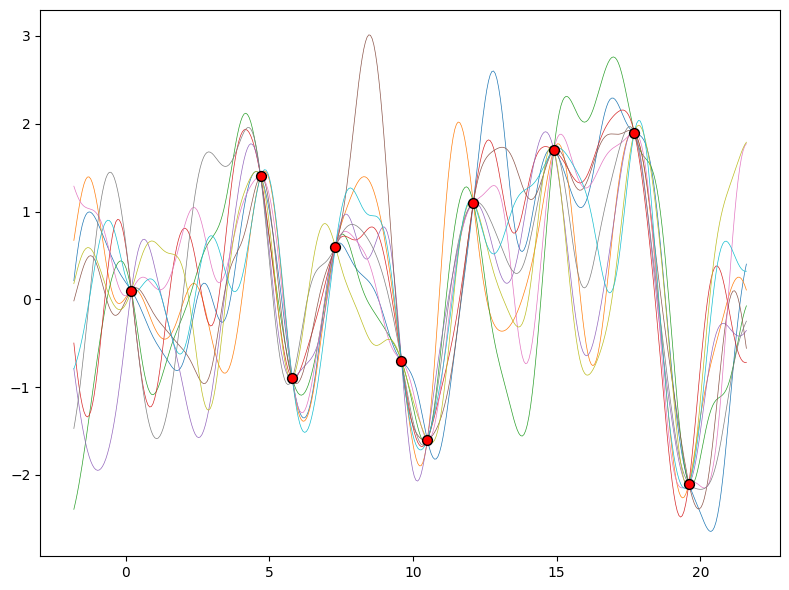

In [49]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.pyplot as plt

X_train = x.reshape(-1, 1)
y_train = y
x_test = np.linspace(min(x)-2, max(x)+2, 400).reshape(-1, 1)  # Extended x values for plotting purposes

# Compute the posterior mean and covariance
K = rbf_kernel(X_train, X_train)
K_s = rbf_kernel(X_train, x_test)
K_ss = rbf_kernel(x_test, x_test)
K_inv = np.linalg.inv(K)

# Computation for mu_s and cov_s:
mu_s = K_s.T.dot(K_inv).dot(y_train)
cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

# Sampling several functions from the posterior
num_samples = 10
f_post = np.random.multivariate_normal(mu_s, cov_s, num_samples)

# Plot the data and the sampled functions
plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, c='red', s=50, zorder=10, edgecolors=(0, 0, 0))
for i in range(num_samples):
    plt.plot(x_test, f_post[i], lw=0.5)
plt.tight_layout()
plt.show()

We may also want a representation of uncertainty to know how confident we should be in our predictions. Intuitively, we should have more uncertainty where there is more variability in the sample posterior functions, as this tells us there are many more possible values the true function could take. This type of uncertainty is called epistemic uncertainty, which is the reducible uncertainty associated with a lack of information. As we acquire more data, this type of uncertainty disappears, as there will be increasingly fewer solutions consistent with what we observe. Like with the posterior mean, we can compute the posterior variance (the variability of these functions in the posterior) in closed form. With shade, we show two times the posterior standard deviation on either side of the mean, creating a credible interval with a 95% probability of containing the true value of the function for any input $x$.

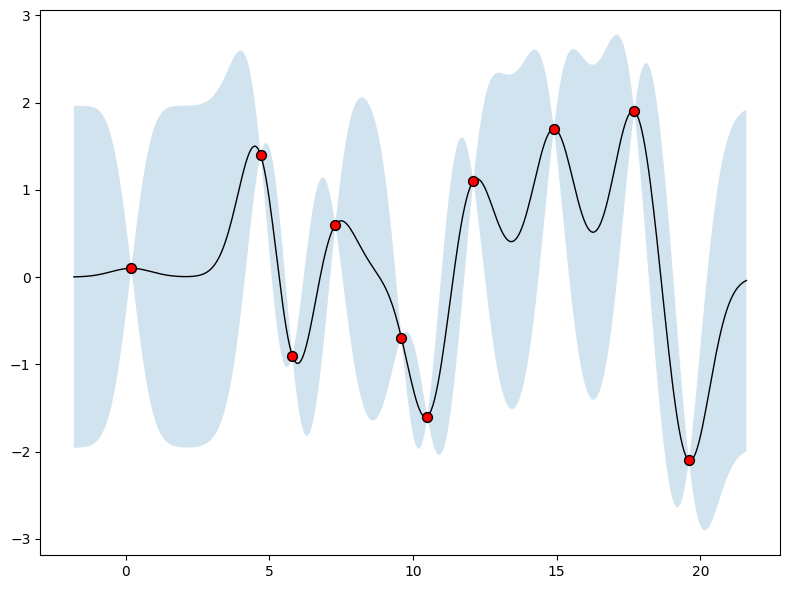

In [50]:
# Generating the x and y data arrays with floats
X_train = x.reshape(-1, 1)
y_train = y
x_test = np.linspace(min(x)-2, max(x)+2, 400).reshape(-1, 1)  # Extended x values for plotting purposes

# Compute the posterior mean and covariance
K = rbf_kernel(X_train, X_train)
K_s = rbf_kernel(X_train, x_test)
K_ss = rbf_kernel(x_test, x_test)
K_inv = np.linalg.inv(K)

# Computation for mu_s and cov_s:
mu_s = K_s.T.dot(K_inv).dot(y_train)
cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

# Plot the data, the mean, and 95% confidence interval of the posterior
plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, c='red', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.plot(x_test, mu_s, 'k', lw=1, zorder=9)
plt.fill_between(x_test.flatten(), mu_s - 1.96*np.sqrt(np.diag(cov_s)), mu_s + 1.96*np.sqrt(np.diag(cov_s)), alpha=0.2)
plt.tight_layout()
plt.show()

## RBF Kernel Parametric study:

The properties of the Gaussian process that we used to fit the data are strongly controlled by what's called a _covariance function_, also known as a _kernel_. The covariance function we used is called the _RBF (Radial Basis Function) kernel_, which has the form
$$ k_{\textrm{RBF}}(x,x') = \textrm{Cov}(f(x),f(x')) = a^2 \exp\left(-\frac{1}{2\ell^2}||x-x'||^2\right) $$

The _hyperparameters_ of this kernel are interpretable. The _amplitude_ parameter $a$ controls the vertical scale over which the function is varying, and the _length-scale_ parameter
$\ell$
controls the rate of variation (the wiggliness) of the function. Larger $a$ means larger function values, and larger
$\ell$
means more slowly varying functions. Let's see what happens to our sample prior and posterior functions as we vary $a$ and
$\ell$.

The _length-scale_ has a particularly pronounced effect on the predictions and uncertainty of a GP. At
$||x-x'|| = \ell$
, the covariance between a pair of function values is $a^2\exp(-0.5)$. At larger distances than
$\ell$
, the values of the function values becomes nearly uncorrelated. This means that if we want to make a prediction at a point $x_*$, then function values with inputs $x$ such that
$||x-x'||>\ell$
will not have a strong effect on our predictions.

Let's see how changing the lengthscale affects sample prior and posterior functions, and credible sets. The above fits use a length-scale of $2$. Let's now consider
$\ell = 0.1, 0.5, 2, 5, 10$
. A length-scale of $0.1$ is very small relative to the range of the input domain we are considering, $25$. For example, the values of the function at $x=5$ and $x=10$ will have essentially no correlation at such a length-scale. On the other hand, for a length-scale of $10$, the function values at these inputs will be highly correlated. Note that the vertical scale changes in the following figures.

In [57]:
import numpy as np
import matplotlib.pyplot as plt

def rbf_kernel_custom(x, x_prime, amplitude=1.0, length_scale=1.0):
    """Computes the RBF kernel for input vectors x and x_prime."""
    sqdist = np.sum(x**2, 1).reshape(-1, 1) + np.sum(x_prime**2, 1) - 2 * np.dot(x, x_prime.T)
    return amplitude**2 * np.exp(-0.5 / length_scale**2 * sqdist)

# Generating the x and y data
X_train = x.reshape(-1, 1)
y_train = y
x_test = np.linspace(min(x)-2, max(x)+2, 400).reshape(-1, 1)

In [52]:
def gp_rbf(amplitude, length_scale):
    # Compute the posterior mean and covariance using custom RBF kernel
    K = rbf_kernel_custom(X_train, X_train, amplitude=1, length_scale=1)
    K_s = rbf_kernel_custom(X_train, x_test, amplitude=1, length_scale=1)
    K_ss = rbf_kernel_custom(x_test, x_test, amplitude=1, length_scale=1)
    K_inv = np.linalg.inv(K)

    mu_s = K_s.T.dot(K_inv).dot(y_train)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

    # Sampling several functions from the posterior
    num_samples = 10
    f_post = np.random.multivariate_normal(mu_s, cov_s, num_samples)

    # Plot the data and the sampled functions
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train, y_train, c='red', s=50, zorder=10, edgecolors=(0, 0, 0))
    for i in range(num_samples):
        plt.plot(x_test, f_post[i], lw=0.5)
    plt.tight_layout()
    plt.title('GP with RBF Kernel (length_scale=' + str(length_scale) + ', amplitude=' + str(amplitude) + ')')
    plt.show()

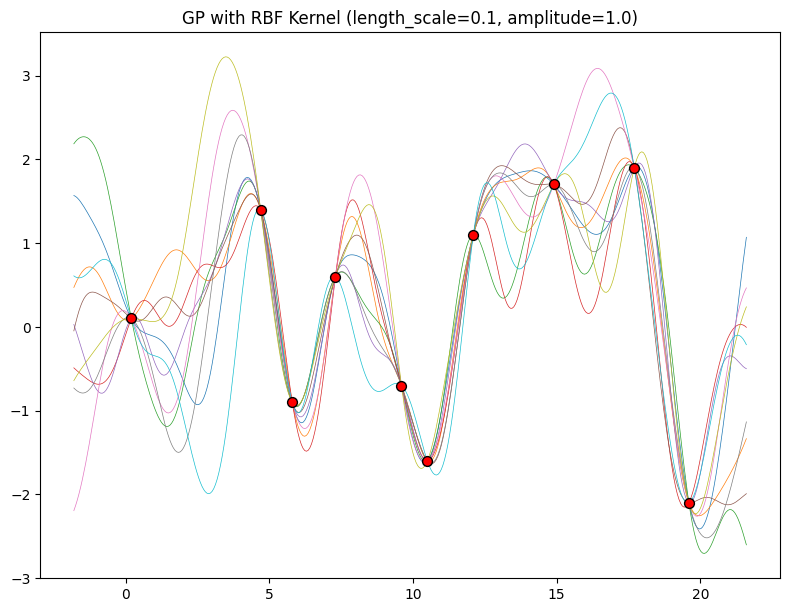

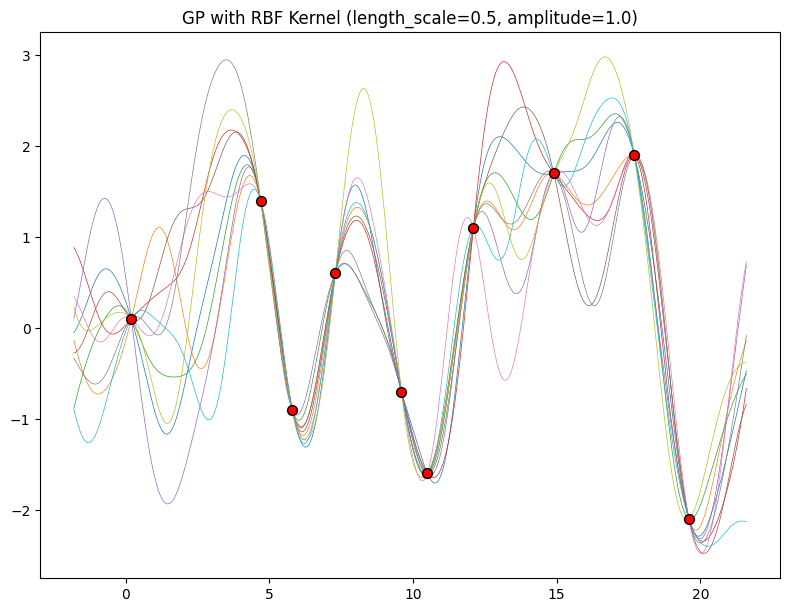

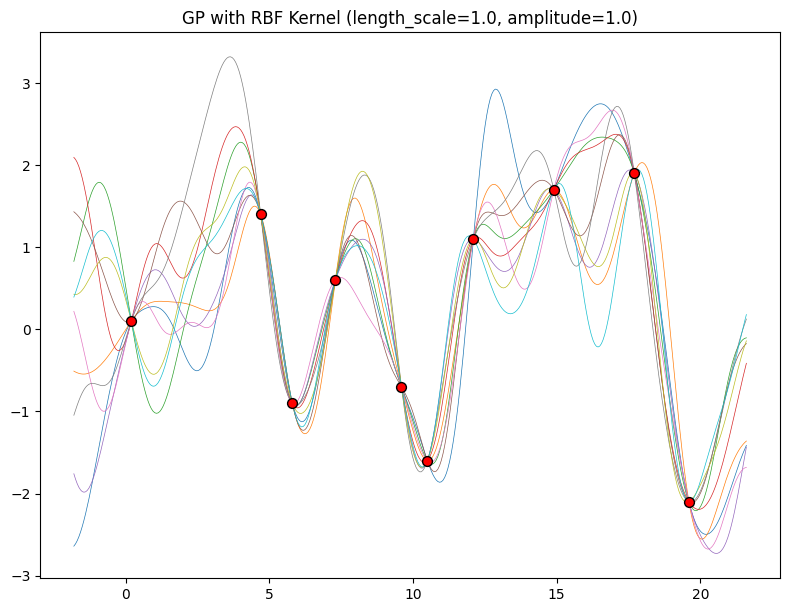

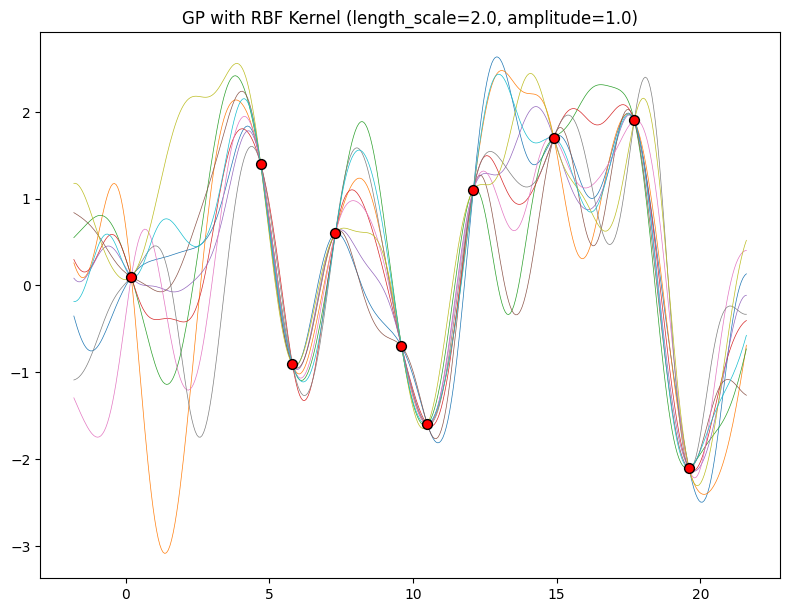

In [53]:
for lscale in [0.1, 0.5, 1.0, 2.0]:
  gp_rbf(amplitude=1.0, length_scale=lscale)

Notice as the length-scale increases the 'wiggliness' of the functions decrease, and our uncertainty decreases. If the length-scale is small, the uncertainty will quickly increase as we move away from the data, as the datapoints become less informative about the function values.


Now, let's vary the amplitude parameter, holding the length-scale fixed at $2$. Note the vertical scale is held fixed for the prior samples, and varies for the posterior samples, so you can clearly see both the increasing scale of the function, and the fits to the data.

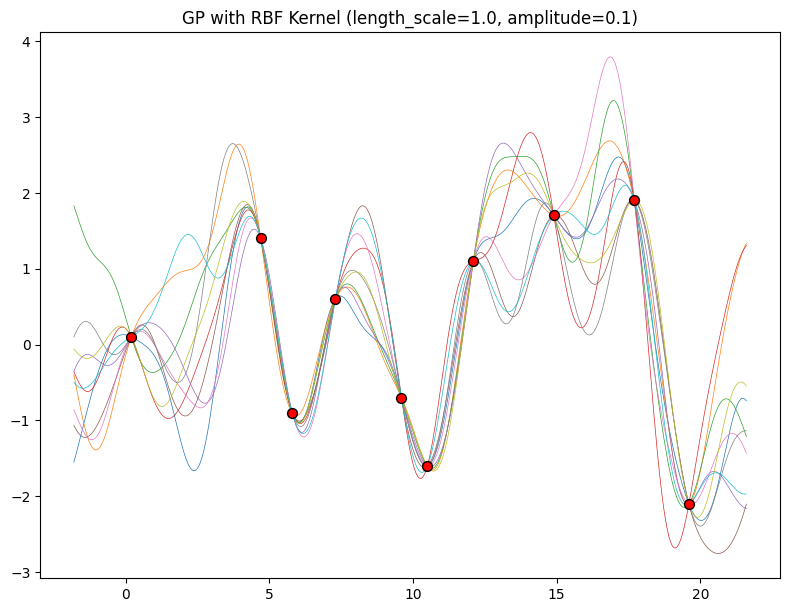

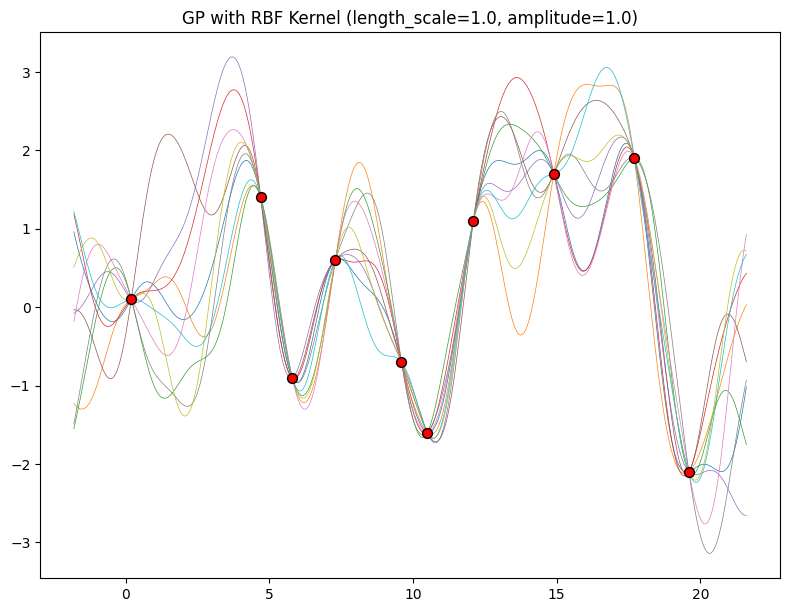

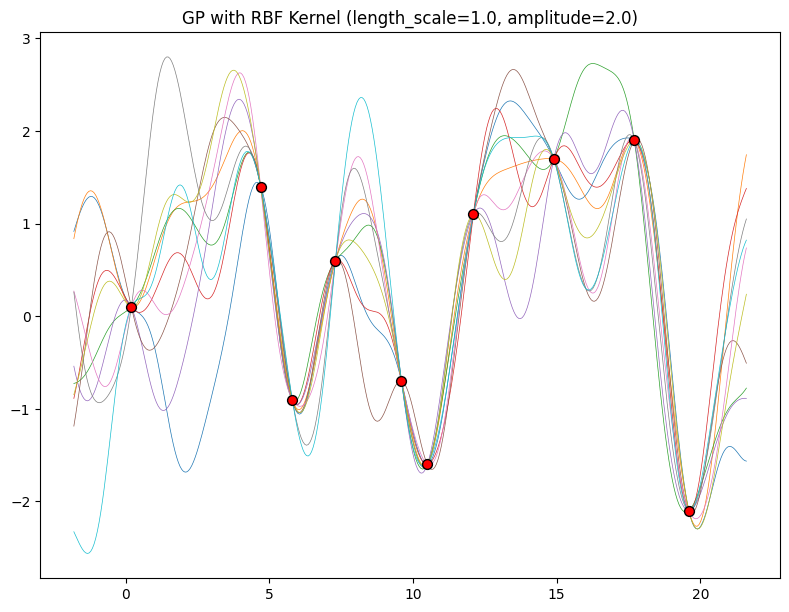

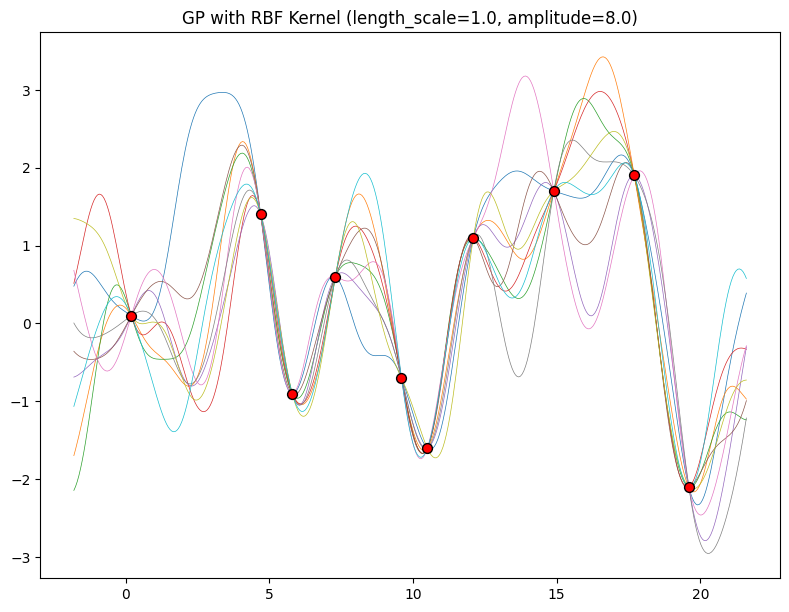

In [54]:
for amplitude in [0.1, 1.0, 2.0, 8.0]:
  gp_rbf(amplitude=amplitude, length_scale=1.0)

We see the amplitude parameter affects the scale of the function, but not the rate of variation. At this point, we also have the sense that the generalization performance of our procedure will depend on having reasonable values for these hyperparameters. Values of $\ell=2$ and $a=1$ appeared to provide reasonable fits, while some of the other values did not. Fortunately, there is a robust and automatic way to specify these hyperparameters, using what is called the _marginal likelihood_, which we will return to in the notebook on inference.

So what is a GP, really? As we started, a GP simply says that any collection of function values
$f(x_1),\dots,f(x_n)$,
indexed by any collection of inputs
$x_1,\dots,x_n$
has a joint multivariate Gaussian distribution. The mean vector $\mu$ of this distribution is given by a _mean function_, which is typically taken to be a constant or zero. The covariance matrix of this distribution is given by the _kernel_ evaluated at all pairs of the inputs $x$.

$$\begin{bmatrix}f(x) \\f(x_1) \\ \vdots \\ f(x_n) \end{bmatrix}\sim \mathcal{N}\left(\mu, \begin{bmatrix}k(x,x) & k(x, x_1) & \dots & k(x,x_n) \\ k(x_1,x) & k(x_1,x_1) & \dots & k(x_1,x_n) \\ \vdots & \vdots & \ddots & \vdots \\ k(x_n, x) & k(x_n, x_1) & \dots & k(x_n,x_n) \end{bmatrix}\right)$$
:eqlabel:`eq_gp_prior`

Equation :eqref:`eq_gp_prior` specifies a GP prior. We can compute the conditional distribution of $f(x)$ for any $x$ given $f(x_1), \dots, f(x_n)$, the function values we have observed. This conditional distribution is called the _posterior_, and it is what we use to make predictions.

In particular,

$$f(x) | f(x_1), \dots, f(x_n) \sim \mathcal{N}(m,s^2)$$

where

$$m = k(x,x_{1:n}) k(x_{1:n},x_{1:n})^{-1} f(x_{1:n})$$

$$s^2 = k(x,x) - k(x,x_{1:n})k(x_{1:n},x_{1:n})^{-1}k(x,x_{1:n})$$

where $k(x,x_{1:n})$ is a $1 \times n$ vector formed by evaluating $k(x,x_{i})$ for $i=1,\dots,n$ and $k(x_{1:n},x_{1:n})$ is an $n \times n$ matrix formed by evaluating $k(x_i,x_j)$ for $i,j = 1,\dots,n$. $m$ is what we can use as a point predictor for any $x$, and $s^2$ is what we use for uncertainty: if we want to create an interval with a 95% probability that $f(x)$ is in the interval, we would use $m \pm 2s$. The predictive means and uncertainties for all the above figures were created using these equations. The observed data points were given by
$f(x_1), \dots, f(x_n)$
and chose a fine grained set of $x$ points to make predictions.

Let's suppose we observe a single datapoint, $f(x_1)$, and we want to determine the value of $f(x)$ at some $x$. Because $f(x)$ is described by a Gaussian process, we know the joint distribution over
$(f(x), f(x_1))$
is Gaussian:

$$
\begin{bmatrix}
f(x) \\
f(x_1) \\
\end{bmatrix}
\sim
\mathcal{N}\left(\mu,
\begin{bmatrix}
k(x,x) & k(x, x_1) \\
k(x_1,x) & k(x_1,x_1)
\end{bmatrix}
\right)
$$

The off-diagonal expression $k(x,x_1) = k(x_1,x)$
tells us how correlated the function values will be --- how strongly determined $f(x)$
will be from $f(x_1)$.
We have seen already that if we use a large length-scale, relative to the distance between $x$ and $x_1$,
$||x-x_1||$, then the function values will be highly correlated. We can visualize the process of determining $f(x)$ from $f(x_1)$ both in the space of functions, and in the joint distribution over $f(x_1), f(x)$. Let's initially consider an $x$ such that $k(x,x_1) = 0.9$, and $k(x,x)=1$, meaning that the value of $f(x)$ is moderately correlated with the value of $f(x_1)$. In the joint distribution, the contours of constant probability will be relatively narrow ellipses.

Suppose we observe $f(x_1) = 1.2$.
To condition on this value of $f(x_1)$,
we can draw a horizontal line at $1.2$ on our plot of the density, and see that the value of $f(x)$
is mostly constrained to $[0.64,1.52]$. We have also drawn this plot in function space, showing the observed
point $f(x_1)$ in orange, and 1 standard deviation of the Gaussian process predictive distribution for $f(x)$
in blue, about the mean value of $1.08$.

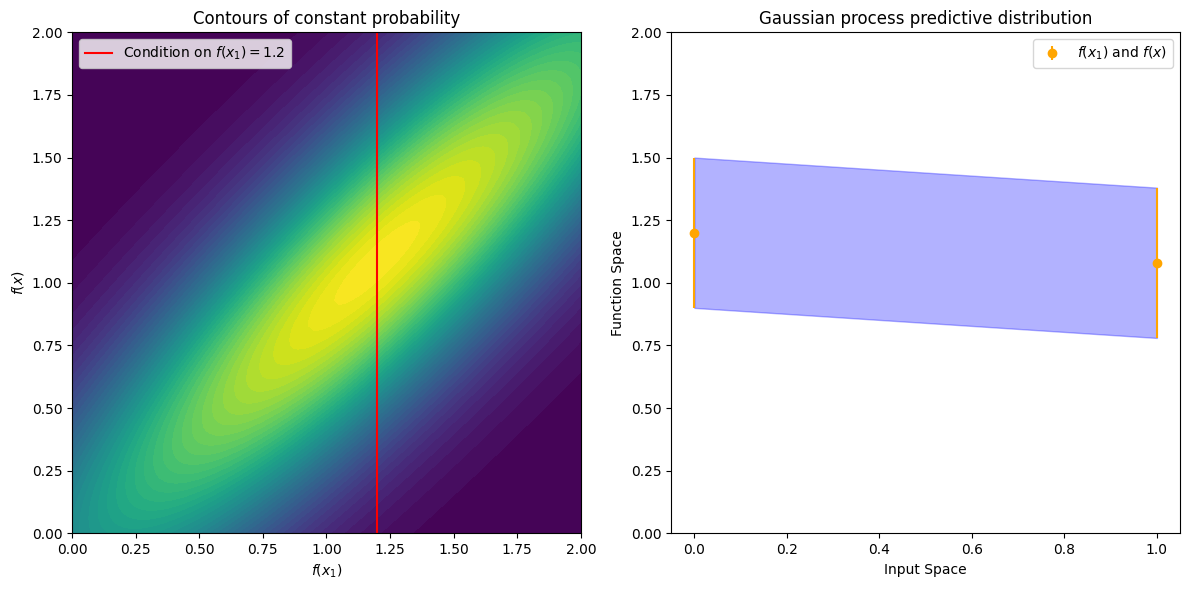

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Define the mean and covariance for the joint Gaussian of f(x1) and f(x)
mu = np.array([1.2, 1.08]) # mean values for f(x1) and f(x)
cov = np.array([[1.0, 0.9], [0.9, 1.0]]) # covariance matrix with k(x,x1) = 0.9

# Generate the grid for the contour plot
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# Compute the bivariate Gaussian density
rv = multivariate_normal(mu, cov)
Z = rv.pdf(pos)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Contour plot
contour = axs[0].contourf(X, Y, Z, levels=50, cmap='viridis')
axs[0].set_xlabel('$f(x_1)$')
axs[0].set_ylabel('$f(x)$')
axs[0].plot([1.2, 1.2], [0, 2], 'r-', label="Condition on $f(x_1) = 1.2$")
axs[0].legend()
axs[0].set_title('Contours of constant probability')

# Gaussian process in function space
axs[1].errorbar([0, 1], [1.2, 1.08], yerr=[0.3, 0.3], fmt='o', color='orange', label='$f(x_1)$ and $f(x)$')
axs[1].fill_between([0, 1], [0.9, 0.78], [1.5, 1.38], color='blue', alpha=0.3)
axs[1].set_ylim([0, 2])
axs[1].set_xlabel('Input Space')
axs[1].set_ylabel('Function Space')
axs[1].set_title('Gaussian process predictive distribution')
axs[1].legend()

plt.tight_layout()
plt.show()


> The left plot shows contours of constant probability for the bivariate Gaussian density over $f(x1)$ and $f(x)$ with a red line indicating $f(x1)=1.2$. The right plot shows the Gaussian process predictive distribution in function space with the observed point $f(x1)$ in orange and 1 standard deviation of the Gaussian process predictive distribution for $f(x)$ in blue.

Now suppose we have a stronger correlation, $k(x,x_1) = 0.95$.
Now the ellipses have narrowed further, and the value of $f(x)$
is even more strongly determined by $f(x_1)$. Drawing a horizontal line at $1.2$, we see the contours for $f(x)$
support values mostly within $[0.83, 1.45]$. Again, we also show the plot in function space, with one standard
deviation about the mean predictive value of $1.14$.

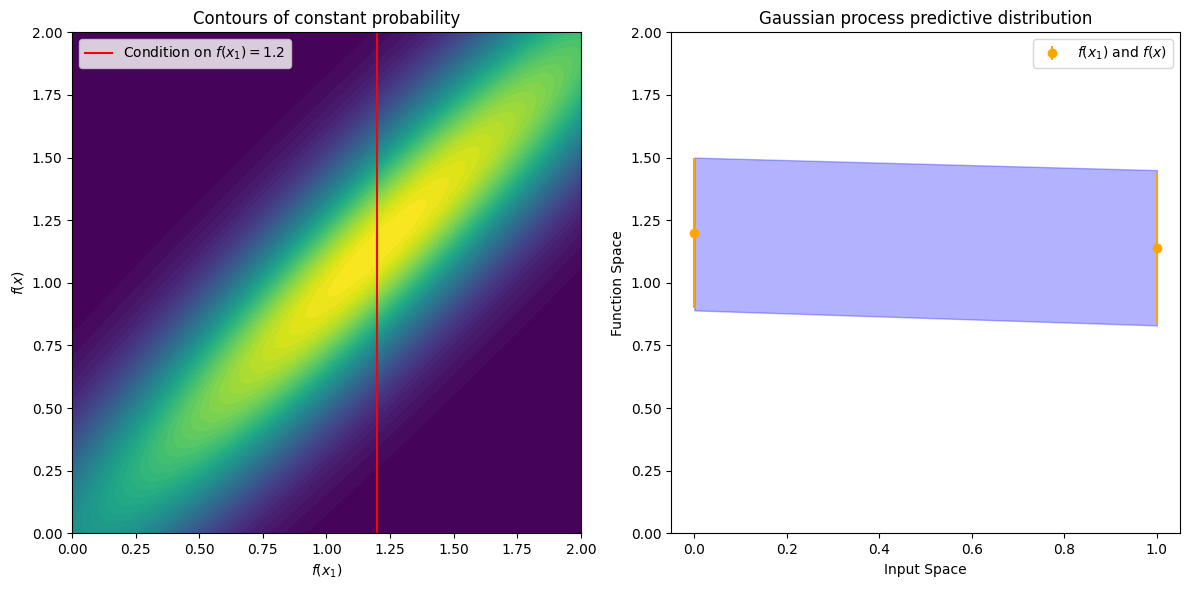

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Define the mean and covariance for the joint Gaussian of f(x1) and f(x)
mu = np.array([1.2, 1.14]) # updated mean values for f(x1) and f(x)
cov = np.array([[1.0, 0.95], [0.95, 1.0]]) # updated covariance matrix with k(x,x1) = 0.95

# Generate the grid for the contour plot
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# Compute the bivariate Gaussian density
rv = multivariate_normal(mu, cov)
Z = rv.pdf(pos)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Contour plot
contour = axs[0].contourf(X, Y, Z, levels=50, cmap='viridis')
axs[0].set_xlabel('$f(x_1)$')
axs[0].set_ylabel('$f(x)$')
axs[0].plot([1.2, 1.2], [0, 2], 'r-', label="Condition on $f(x_1) = 1.2$")
axs[0].legend()
axs[0].set_title('Contours of constant probability')

# Gaussian process in function space
axs[1].errorbar([0, 1], [1.2, 1.14], yerr=[0.3, 0.3], fmt='o', color='orange', label='$f(x_1)$ and $f(x)$')
axs[1].fill_between([0, 1], [0.89, 0.83], [1.5, 1.45], color='blue', alpha=0.3)
axs[1].set_ylim([0, 2])
axs[1].set_xlabel('Input Space')
axs[1].set_ylabel('Function Space')
axs[1].set_title('Gaussian process predictive distribution')
axs[1].legend()

plt.tight_layout()
plt.show()

We see that the posterior mean predictor of our Gaussian process is closer to $1.2$, because there is now a stronger correlation. We also see that our uncertainty (the error bars) have somewhat decreased. Despite the strong correlation between these function values, our uncertainty is still righly quite large, because we have only observed a single data point!

This procedure can give us a posterior on $f(x)$ for any $x$, for any number of points we have observed. Suppose we observe $f(x_1), f(x_2)$. We now visualize the posterior for $f(x)$ at a particular $x=x'$ in function space. The exact distribution for $f(x)$ is given by the above equations. $f(x)$ is Gaussian distributed, with mean

$$m = k(x,x_{1:3}) k(x_{1:3},x_{1:3})^{-1} f(x_{1:3})$$

and variance

$$s^2 = k(x,x) - k(x,x_{1:3})k(x_{1:3},x_{1:3})^{-1}k(x,x_{1:3})$$

We have been considering _noise free_ observations. As we will see, it is easy to include observation noise. If we assume that the data are generated from a latent noise free function $f(x)$ plus iid Gaussian noise
$\epsilon(x) \sim \mathcal{N}(0,\sigma^2)$
with variance $\sigma^2$, then our covariance function simply becomes
$k(x_i,x_j) \to k(x_i,x_j) + \delta_{ij}\sigma^2$,
where $\delta_{ij} = 1$ if $i=j$ and $0$ otherwise.